## import

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 下载数据

In [4]:
def download(name, cache_dir=os.path.join('.', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [6]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

## 数据预处理

In [7]:
#把第一列：ID列删除 和训练数据最后一列价格删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#得到所有是数字的特征
num_features = all_features.dtypes[all_features.dtypes != 'object'].index

all_features[num_features]=all_features[num_features].apply(lambda x:(x-x.mean())/(x.std()))
#? 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[num_features] = all_features[num_features].fillna(0)
#! one-hot 编码str;`Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
#创建labels
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

## Training

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [9]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K 折交叉验证

In [10]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 3:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel=f'epoch{i}', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.124171, valid log rmse 0.164737
fold 2, train log rmse 0.118472, valid log rmse 0.168796
fold 3, train log rmse 0.118792, valid log rmse 0.155921
fold 4, train log rmse 0.123871, valid log rmse 0.151832
fold 5, train log rmse 0.114282, valid log rmse 0.162087
5-折验证:平均训练log rmse:0.119918,平均验证log rmse:0.160675


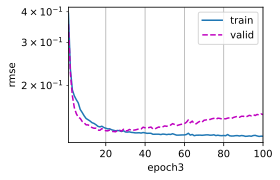

In [71]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.136200, valid log rmse 0.144303
fold 2, train log rmse 0.132856, valid log rmse 0.162315
fold 3, train log rmse 0.131278, valid log rmse 0.156333
fold 4, train log rmse 0.135170, valid log rmse 0.131551
fold 5, train log rmse 0.124227, valid log rmse 0.158583
5-折验证:平均训练log rmse:0.131946,平均验证log rmse:0.150617


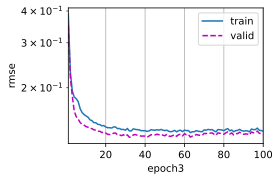

In [73]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.1, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.126605, valid log rmse 0.152252
fold 2, train log rmse 0.120243, valid log rmse 0.155772
fold 3, train log rmse 0.121997, valid log rmse 0.152612
fold 4, train log rmse 0.126322, valid log rmse 0.135251
fold 5, train log rmse 0.118094, valid log rmse 0.160634
5-折验证:平均训练log rmse:0.122652,平均验证log rmse:0.151304


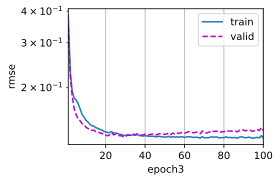

In [11]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.01, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.349478, valid log rmse 0.153412
fold 2, train log rmse 0.160713, valid log rmse 0.641139
fold 3, train log rmse 0.344208, valid log rmse 0.205095
fold 4, train log rmse 0.348396, valid log rmse 0.145113
fold 5, train log rmse 0.342847, valid log rmse 0.173654
5-折验证:平均训练log rmse:0.309128,平均验证log rmse:0.263683


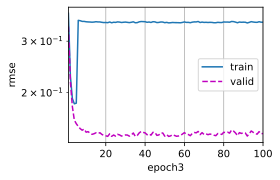

In [12]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.5, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.149795, valid log rmse 0.146442
fold 2, train log rmse 0.138581, valid log rmse 0.238734
fold 3, train log rmse 0.140917, valid log rmse 0.162593
fold 4, train log rmse 0.150732, valid log rmse 0.138664
fold 5, train log rmse 0.141096, valid log rmse 0.164108
5-折验证:平均训练log rmse:0.144224,平均验证log rmse:0.170108


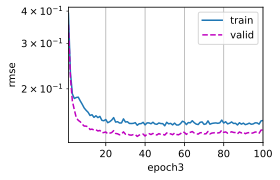

In [13]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.2, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.05, 1
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.127333, valid log rmse 0.145084
fold 2, train log rmse 0.123678, valid log rmse 0.147665
fold 3, train log rmse 0.123423, valid log rmse 0.149086
fold 4, train log rmse 0.128531, valid log rmse 0.132759
fold 5, train log rmse 0.119616, valid log rmse 0.160164
5-折验证:平均训练log rmse:0.124516,平均验证log rmse:0.146952


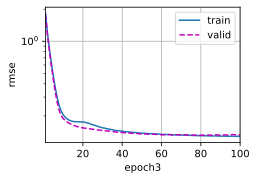

In [72]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 8
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.132732, valid log rmse 0.141475
fold 2, train log rmse 0.129327, valid log rmse 0.146489
fold 3, train log rmse 0.128673, valid log rmse 0.145205
fold 4, train log rmse 0.134055, valid log rmse 0.133922
fold 5, train log rmse 0.126332, valid log rmse 0.164126
5-折验证:平均训练log rmse:0.130224,平均验证log rmse:0.146243


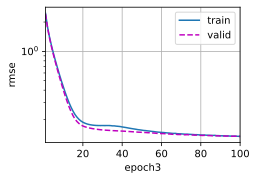

In [74]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 16
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.149573, valid log rmse 0.146894
fold 2, train log rmse 0.145366, valid log rmse 0.163158
fold 3, train log rmse 0.143075, valid log rmse 0.149831
fold 4, train log rmse 0.148646, valid log rmse 0.146179
fold 5, train log rmse 0.143202, valid log rmse 0.173178
5-折验证:平均训练log rmse:0.145972,平均验证log rmse:0.155848


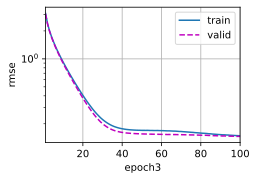

In [75]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 32
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.135664, valid log rmse 0.142153
fold 2, train log rmse 0.132621, valid log rmse 0.148499
fold 3, train log rmse 0.131007, valid log rmse 0.144679
fold 4, train log rmse 0.136802, valid log rmse 0.135268
fold 5, train log rmse 0.128676, valid log rmse 0.165392
5-折验证:平均训练log rmse:0.132954,平均验证log rmse:0.147198


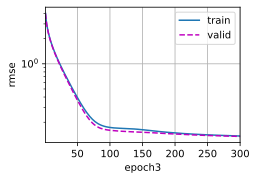

In [90]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 2, 0.01, 16
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.129956, valid log rmse 0.142408
fold 2, train log rmse 0.126488, valid log rmse 0.146395
fold 3, train log rmse 0.125824, valid log rmse 0.147765
fold 4, train log rmse 0.131256, valid log rmse 0.131397
fold 5, train log rmse 0.122478, valid log rmse 0.160761
5-折验证:平均训练log rmse:0.127200,平均验证log rmse:0.145745


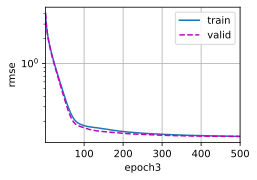

In [78]:
k, num_epochs, lr, weight_decay, batch_size = 5, 500, 1, 0, 16
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.128616, valid log rmse 0.148412
fold 2, train log rmse 0.129293, valid log rmse 0.116679
fold 3, train log rmse 0.128931, valid log rmse 0.126469
fold 4, train log rmse 0.124380, valid log rmse 0.161609
fold 5, train log rmse 0.124008, valid log rmse 0.165398
fold 6, train log rmse 0.129027, valid log rmse 0.124399
fold 7, train log rmse 0.128919, valid log rmse 0.126263
fold 8, train log rmse 0.128961, valid log rmse 0.131828
fold 9, train log rmse 0.121449, valid log rmse 0.179614
fold 10, train log rmse 0.128194, valid log rmse 0.133933
10-折验证:平均训练log rmse:0.127178,平均验证log rmse:0.141460


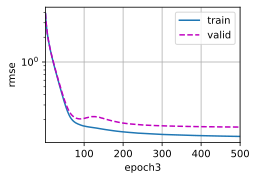

In [79]:
k, num_epochs, lr, weight_decay, batch_size = 10, 500, 1, 0, 16
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.129211, valid log rmse 0.146852
fold 2, train log rmse 0.130048, valid log rmse 0.116532
fold 3, train log rmse 0.129748, valid log rmse 0.127277
fold 4, train log rmse 0.125012, valid log rmse 0.161544
fold 5, train log rmse 0.124606, valid log rmse 0.166353
fold 6, train log rmse 0.129792, valid log rmse 0.123321
fold 7, train log rmse 0.129885, valid log rmse 0.124483
fold 8, train log rmse 0.129490, valid log rmse 0.131698
fold 9, train log rmse 0.122141, valid log rmse 0.179777
fold 10, train log rmse 0.129024, valid log rmse 0.133233
10-折验证:平均训练log rmse:0.127896,平均验证log rmse:0.141107


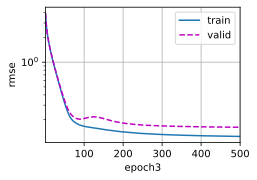

In [81]:
k, num_epochs, lr, weight_decay, batch_size = 10, 500, 1, 0.01, 16
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.338506, valid log rmse 0.163508
fold 2, train log rmse 0.179179, valid log rmse 0.156846
fold 3, train log rmse 0.184622, valid log rmse 0.161443
fold 4, train log rmse 0.167992, valid log rmse 0.385954
fold 5, train log rmse 0.188249, valid log rmse 0.221902
fold 6, train log rmse 0.182593, valid log rmse 0.139745
fold 7, train log rmse 0.193832, valid log rmse 0.150461
fold 8, train log rmse 0.185095, valid log rmse 0.162589
fold 9, train log rmse 0.335283, valid log rmse 0.208591
fold 10, train log rmse 0.186405, valid log rmse 0.160518
10-折验证:平均训练log rmse:0.214176,平均验证log rmse:0.191156


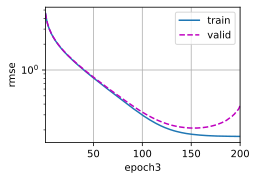

In [85]:
k, num_epochs, lr, weight_decay, batch_size = 10, 200, 1, 0.3, 32
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.168575, valid log rmse 0.157150
fold 2, train log rmse 0.167238, valid log rmse 0.153936
fold 3, train log rmse 0.168052, valid log rmse 0.156283
fold 4, train log rmse 0.161220, valid log rmse 0.210301
fold 5, train log rmse 0.162813, valid log rmse 0.202391
fold 6, train log rmse 0.168713, valid log rmse 0.137366
fold 7, train log rmse 0.167602, valid log rmse 0.145704
fold 8, train log rmse 0.166142, valid log rmse 0.161816
fold 9, train log rmse 0.162456, valid log rmse 0.202099
fold 10, train log rmse 0.166783, valid log rmse 0.158766
10-折验证:平均训练log rmse:0.165959,平均验证log rmse:0.168581


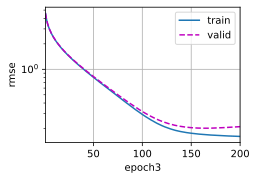

In [86]:
k, num_epochs, lr, weight_decay, batch_size = 10, 200, 1, 0.01, 32
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')

fold 1, train log rmse 0.175624, valid log rmse 0.158869
fold 2, train log rmse 0.163021, valid log rmse 0.196422
fold 3, train log rmse 0.173337, valid log rmse 0.160636
fold 4, train log rmse 0.167150, valid log rmse 0.176695
4-折验证:平均训练log rmse:0.169783,平均验证log rmse:0.173155


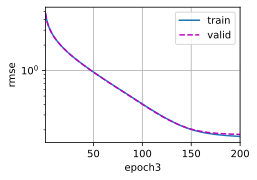

In [89]:
k, num_epochs, lr, weight_decay, batch_size = 4, 200, 1, 0.001, 32
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证:平均训练log rmse:{float(train_l):f},'f'平均验证log rmse:{float(valid_l):f}')